## Init

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq.chat_models import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
from langchain_core.runnables import RunnableParallel
from langchain_core.messages import HumanMessage, AIMessage
import warnings

warnings.filterwarnings("ignore")
load_dotenv(find_dotenv())

True

In [3]:
GROQ_API_KEY = os.getenv("GROQQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]=LANGCHAIN_API_KEY
os.environ["LANGCHAIN_PROJECT"]="advanced-rag"
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

## Query transformation

- Lần lượt lấy từng chunks thực hiện query translation (sinh ra các query làm nhiệm vụ tìm kiếm luật) (phuc) - chưa làm nhưng ở trong code có sẵn prompt (tạo prompt tiếng nhật)

In [4]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
# Template for generating multiple perspectives on a user question
template = """あなたはAI言語モデルアシスタントです。あなたのタスクは、与えられた契約文の正当性を証明するために関連する法律を検索するための5つの異なるバージョンの質問を生成することです。元の契約文に対して異なる視点からの質問を作成することで、距離ベースの類似検索の限界を克服し、より適切な法的情報を取得できるようにします。これらの代替質問を改行で区切って提供してください。

元の契約文: {contract_clause}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | ChatGroq(temperature=0)   # thực chất là một model LLMs 
    | StrOutputParser()         # chuyển đổi output từ model LLMs thành dạng string
    | (lambda x: x.split("\n")) # tách các câu hỏi thành list các câu hỏi
) # kết quả trả về là list các câu hỏi

In [ ]:
generate_queries.invoke({"contract_clause":"雇用主は従業員を解雇する場合、少なくとも 40 日前に通知する必要があります。"})

['1. 雇用法に基づいて、雇用主が従業員を解雇する場合、通知期間は legally how many days in advance should it be given?',
 "2. From the employee's perspective, what is the required notice period for termination according to labor laws?",
 '3. Are there any exceptions to the 40-day notice requirement for employers when terminating employees under specific circumstances?',
 "4. How does the 40-day notice period in this contract compare to other jurisdictions' employment termination notice requirements?",
 '5. How does the 40-day notice period in this contract align with the recommended best practices for employment termination notice periods?']

Failed to multipart ingest runs: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=a4a04153-7360-403f-ba37-c0727781e08f,id=a4a04153-7360-403f-ba37-c0727781e08f; trace=a4a04153-7360-403f-ba37-c0727781e08f,id=44729b61-44b3-4994-8056-117f2853ef4c; trace=a4a04153-7360-403f-ba37-c0727781e08f,id=318665bd-3a4d-4c43-8f9d-8092ce98803f
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')
Failed to send comp

## Routing

- Mỗi chunks thực hiện routingLLM để chọn ra route phù hợp. Route là danh sách các vectorDB về luật (đã tạo). Sau đó LLMs duyệt lại các route đó và trả về các route liên quan. (phuc)

In [6]:
# # Danh sách các vectorDB
# # 1 
# "category": "Labor Laws",
#         "description": "Laws related to labor, employment, and worker's rights.",
# # 2
# "category": "Social Security and Insurance Laws",
#         "description": "Laws related to social security, insurance, and benefits for workers and citizens.",
# # 3
# "category": "Public Service and Government Laws",
#         "description": "Laws related to public service, government employees, and government agencies.",
# # 4
# "category": "Education and Research Laws",
#         "description": "Laws related to education, research, and academic institutions.",
# # 5
# "category": "Health and Welfare Laws",
#         "description": "Laws related to health, welfare, and social services.",
# # 6
# "category": "Judicial and Legal System Laws",
#         "description": "Laws related to the judicial system, legal procedures, and law enforcement.",
# # 7
# "category": "Miscellaneous Laws",
#         "description": "Laws that do not fit into the above categories, including laws related to information disclosure, environmental protection, and other miscellaneous topics.",

In [7]:
from pydantic import BaseModel

class LaborLawsVectorStore(BaseModel):
    """
    A vectorstore contains information about labor laws, employment regulations,
    worker's rights, and related legal frameworks.
    """
    query: str

class SocialSecurityVectorStore(BaseModel):
    """
    A vectorstore contains information about social security laws, insurance policies,
    and benefits for workers and citizens.
    """
    query: str

class PublicServiceVectorStore(BaseModel):
    """
    A vectorstore contains information about laws related to public service,
    government employees, and government agencies.
    """
    query: str

class EducationResearchVectorStore(BaseModel):
    """
    A vectorstore contains information about laws related to education, research,
    and academic institutions.
    """
    query: str

class HealthWelfareVectorStore(BaseModel):
    """
    A vectorstore contains information about laws related to health, welfare,
    and social services.
    """
    query: str

class JudicialLegalSystemVectorStore(BaseModel):
    """
    A vectorstore contains information about laws related to the judicial system,
    legal procedures, and law enforcement.
    """
    query: str

class MiscellaneousLawsVectorStore(BaseModel):
    """
    A vectorstore contains information about laws that do not fit into the above categories,
    including laws related to information disclosure, environmental protection, and other topics.
    """
    query: str

In [8]:
router_prompt_template = (
    "あなたは法律の専門家であり、ユーザーのクエリを適切な法律カテゴリの VectorStore に振り分ける役割を担っています。\n"
    "以下の詳細な基準に基づいて、クエリを最適なカテゴリに分類してください。\n\n"

    "### カテゴリの説明:\n"
    "- **労働法 (LaborLawsVectorStore)**:\n"
    "  - 労働契約、解雇、残業、労働時間、最低賃金、職場のハラスメント、労働組合の権利など、雇用関係に関するすべての法律。\n"
    "  - 例: 「従業員を解雇する際の正当な理由とは？」「最低賃金は法律でどのように定められているか？」\n\n"
    
    "- **社会保障法 (SocialSecurityVectorStore)**:\n"
    "  - 年金、健康保険、失業保険、介護保険、生活保護など、社会的セーフティネットに関連する法律。\n"
    "  - 例: 「年金の受給資格は何ですか？」「健康保険に加入しないとどうなる？」\n\n"

    "- **公務員法 (PublicServiceVectorStore)**:\n"
    "  - 国家公務員法、地方公務員法、公務員の職務、給与、倫理規定、懲戒処分に関する法律。\n"
    "  - 例: 「公務員が副業をすることは許されているのか？」「国家公務員と地方公務員の違いは？」\n\n"

    "- **教育・研究法 (EducationResearchVectorStore)**:\n"
    "  - 学校教育法、大学制度、研究助成金、学術論文の著作権、教育機関の運営に関する法律。\n"
    "  - 例: 「日本の義務教育は何歳まで？」「研究費の不正使用はどのように罰せられる？」\n\n"

    "- **医療・福祉法 (HealthWelfareVectorStore)**:\n"
    "  - 医療制度、患者の権利、福祉サービス、高齢者・障害者支援、医療機関の運営に関する法律。\n"
    "  - 例: 「インフォームド・コンセントとは何か？」「介護保険の申請方法は？」\n\n"

    "- **司法・法律制度 (JudicialLegalSystemVectorStore)**:\n"
    "  - 裁判制度、弁護士・検察官・裁判官の職務、刑法、民法、訴訟手続き、法執行機関の活動に関する法律。\n"
    "  - 例: 「刑事裁判と民事裁判の違いは？」「裁判所の判決を不服として上訴する方法は？」\n\n"

    "- **その他の法律 (MiscellaneousLawsVectorStore)**:\n"
    "  - 上記のカテゴリに該当しないが、日本の法律に関連するすべての質問。\n"
    "  - 例: 「環境保護法の内容は？」「情報公開請求の方法を知りたい。」\n\n"

    "### 重要な指示:\n"
    "- ユーザーのクエリが法律に関係ない場合は「法律に関係なし」と返してください。\n"
    "- クエリを慎重に分析し、最も適切なカテゴリを選択してください。\n"
    "- ユーザーの質問が複数のカテゴリにまたがる場合は、最も関連性の高いカテゴリに振り分けてください。\n\n"
    
    "クエリ: {query}"
)


llm = ChatGroq(model="llama3-70b-8192", temperature=0)
prompt = ChatPromptTemplate.from_template(router_prompt_template)
query_router = prompt | llm.bind_tools(
    tools=[
        LaborLawsVectorStore, 
        SocialSecurityVectorStore, 
        PublicServiceVectorStore, 
        EducationResearchVectorStore, 
        HealthWelfareVectorStore, 
        JudicialLegalSystemVectorStore, 
        MiscellaneousLawsVectorStore
    ]
)

In [9]:
# ['1. 労働者の採用に必要なドキュメントについて、個人情報保護法に基づく誓約書は法的に必須ですか？',
#  '2. 新労働法に基づいて、採用された労働者が会社に提出する必要がある初期課税申告について、源泉徴収票はどのように関連していますか？',
#  '3. 労働者の入社に際して、法的に必要な手続きについて、入社誓約書と雇用契約書の違いは何ですか？',
#  '4. 労働者の採用に際して、法的に必要な身元保証について、身元保証書と雇用保険被保険者証の写しの違いは何ですか？',
#  '5. 労働者の採用に必要な身分証明書について、パスポートの写しは法的に有効ですか？それとも、マイナンバーカード又はマイナンバー通知書の写しのみが有効ですか？']

In [10]:
response = query_router.invoke("労働者の採用に必要な身分証明書について、パスポートの写しは法的に有効ですか？それとも、マイナンバーカード又はマイナンバー通知書の写しのみが有効ですか？")
print("tool_calls" in response.additional_kwargs)
print(len(response.additional_kwargs["tool_calls"]))
print(response.additional_kwargs["tool_calls"][0]["function"]["name"])


True
1
LaborLawsVectorStore


## Retrieval

- Sau đó các route tức là các vectorDB (đã được embedding từ trước - có thể gộp lại của nhiều bộ vectorDB được thực chất là gộp các file pickle) thực hiện retrieval (có thể chromaDB hoặc FAISS đã làm) hoặc thực hiện lọc theo metadata hoặc kết hợp 2 phương pháp truy xuất cho từng chunk thu được docs liên quan của chunk đó. Và thông qua LLMs duyệt lại. (phuc)

### Init

In [11]:
import json

with open("./full_corpus_110225_with_metadata.json", "r", encoding="utf-8") as f:
    data_docs = json.load(f)

from langchain_core.documents import Document

docs = []
for doc in data_docs:
    docs.append(
        Document(
            page_content=doc["content"],
            metadata=doc["metadata"]
        )
    )

In [12]:
len(docs)

5016

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
chunks = text_splitter.split_documents(docs)

In [14]:
embedding_function = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")

### Using dense retrieval

In [90]:
import numpy as np
import json
import torch
import pickle
from sentence_transformers import SentenceTransformer, util


class RetrievalData:
    def __init__(self, legal_dict_json, model_paths, legal_data_path, weighted, top_n=20, range_score=0.2, encode_legal_data_flag=False):
        self.legal_dict_json = legal_dict_json
        self.legal_data_path = legal_data_path
        self.weighted = weighted
        self.top_n = top_n
        self.range_score = range_score
        self.models = self.load_models(model_paths)

        if encode_legal_data_flag:
            self.emb_legal_data = self.encode_legal_data()
            with open(self.legal_data_path, "wb") as f:
                pickle.dump(self.emb_legal_data, f)
        else:
            with open(self.legal_data_path, "rb") as f:
                self.emb_legal_data = pickle.load(f)

    def load_models(self, model_paths):
        return [SentenceTransformer(model_path) for model_path in model_paths]

    def encode_legal_data(self):
        doc_data = json.load(open(self.legal_dict_json, encoding='utf-8'))
        list_emb_models = []
        for model in self.models:
            emb2_list = [model.encode(doc["content"]) for doc in doc_data]
            list_emb_models.append(np.array(emb2_list))
        return list_emb_models

    def encode_question(self, question_data):
        return [model.encode(question_data) for model in self.models]

    def calculate_cosine_similarity(self, question_embs, list_embed=None):
        cos_sim = []
        if list_embed != None:
            print("vao no embed")
            for idx, emb_legal in enumerate(list_embed):
                scores = util.cos_sim(question_embs[idx], emb_legal)
                cos_sim.append(self.weighted[idx] * scores)
        else:
            print("vao yes embed")
            for idx, emb_legal in enumerate(self.emb_legal_data):
                scores = util.cos_sim(question_embs[idx], emb_legal)
                cos_sim.append(self.weighted[idx] * scores)
        cos_sim = torch.cat(cos_sim, dim=0)
        cos_sim = torch.sum(cos_sim, dim=0).squeeze(0).numpy()
        return cos_sim

    def process_predictions(self, cos_sim):
        max_score = np.max(cos_sim)
        predictions = np.argpartition(cos_sim, len(cos_sim) - self.top_n)[-self.top_n:]
        new_scores = cos_sim[predictions]
        new_predictions = np.where(new_scores >= (max_score - self.range_score))[0]
        map_ids = predictions[new_predictions]
        new_scores = new_scores[new_scores >= (max_score - self.range_score)]
        if new_scores.shape[0] > self.top_n:
            predictions_2 = np.argpartition(new_scores, len(new_scores) - self.top_n)[-self.top_n:]
            map_ids = map_ids[predictions_2]
        return map_ids, new_scores

    def display_results(self, map_ids):
        dup_ans = []
        with open(self.legal_dict_json, 'r', encoding='utf-8') as file:
            doc_data = json.load(file)
        for idx_pred in map_ids:
            law_id_article = doc_data[idx_pred]["id"]
            content = doc_data[idx_pred]["content"]
            if law_id_article not in dup_ans:
                dup_ans.append(law_id_article)
                print(f'Law and Article ID: {law_id_article}')
                print(f'Text: {content}')
                print("=" * 80)

    def inference(self, question, list_embed=None):
        question_embs = self.encode_question(question)
        cos_sim = self.calculate_cosine_similarity(question_embs, list_embed)
        map_ids, new_scores = self.process_predictions(cos_sim)
        return map_ids, new_scores
        # self.display_results(map_ids)



if __name__ == "__main__":
    model_paths = ["paraphrase-multilingual-mpnet-base-v2", 
                   "distiluse-base-multilingual-cased-v1", 
                   "saved_model_finetune_mlm_lms_round2"]
    legal_dict_json = "generated_data/full_corpus_110225_with_metadata_new.json"
    legal_data_path = "generated_data/vectorDB_full_corpus_110225.pkl"
    weighted = [0.3, 0.2, 0.5]

    retrieval = RetrievalData(legal_dict_json, model_paths, legal_data_path, weighted, encode_legal_data_flag = True)
    
    # while True:
    #     question = input("\nEnter a contract sentence: ").strip()
    #     retrieval.inference(question)
    #     print("=" * 80)

OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB. GPU 0 has a total capacity of 23.65 GiB of which 693.75 MiB is free. Process 1939 has 934.00 MiB memory in use. Process 667668 has 970.00 MiB memory in use. Process 667678 has 1.05 GiB memory in use. Process 667676 has 970.00 MiB memory in use. Process 667670 has 1.05 GiB memory in use. Process 667669 has 970.00 MiB memory in use. Including non-PyTorch memory, this process has 10.35 GiB memory in use. Process 3162342 has 6.72 GiB memory in use. Of the allocated memory 9.37 GiB is allocated by PyTorch, and 552.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
legal_dict_json = "generated_data/full_corpus_110225_with_metadata_new.json"

In [ ]:
def display_results(map_ids, new_scores):
    dup_ans = []
    with open(legal_dict_json, 'r', encoding='utf-8') as file:
        doc_data = json.load(file)
    for idx_pred in map_ids:
        law_id_article = doc_data[idx_pred]["id"]
        content = doc_data[idx_pred]["content"]
        if law_id_article not in dup_ans:
            dup_ans.append(law_id_article)
            print(f'Law and Article ID: {law_id_article}')
            print(f'Text: {content}')
            print("=" * 80)

In [ ]:
def return_documents(map_ids, new_scores):
    dup_ans = []
    with open(legal_dict_json, 'r', encoding='utf-8') as file:
        doc_data = json.load(file)
    test_docs = []
    for idx_pred in map_ids:
        law_id_article = doc_data[idx_pred]["id"]
        content = doc_data[idx_pred]["content"]
        metadata = doc_data[idx_pred]["metadata"]

        if law_id_article not in dup_ans:
            test_docs.append(
                Document(
                    page_content=content,
                    metadata=metadata
                )
            )
            dup_ans.append(law_id_article)
    return test_docs  

In [ ]:
# question = input("\nEnter a contract sentence: ").strip()
question = "雇用主が従業員を解雇する場合、雇用契約で定められている通知期間は、40日以上である必要があるのか？"
map_ids, new_scores = retrieval.inference(question)
documents = return_documents(map_ids, new_scores)
# display_results(map_ids, new_scores)

vao yes embed


In [ ]:
documents

[Document(metadata={'law_number': '平成十九年法律第百二十八号', 'law_name': '労働契約法', 'enactment_year': '令和2年4月1日 施行', 'chapter_number': '第三章', 'chapter_name': '労働契約の継続及び終了', 'division_number': '', 'division_name': '', 'article_number': '第十六条', 'article_name': '解雇', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128'}, page_content='平成十九年法律第百二十八号\u3000労働契約法/第三章\u3000労働契約の継続及び終了/第十六条\u3000解雇/解雇は、客観的に合理的な理由を欠き、社会通念上相当であると認められない場合は、その権利を濫用したものとして、無効とする。'),
 Document(metadata={'law_number': '昭和二十二年法律第四十九号', 'law_name': '労働基準法', 'enactment_year': '令和6年5月31日 施行', 'chapter_number': '第二章', 'chapter_name': '労働契約', 'division_number': '', 'division_name': '', 'article_number': '第二十二条', 'article_name': '退職時等の証明', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約/第二十二条\u3000退職時等の証明/労働者が、退職の場合において、使用期間、業務の種類、その事業における地位、賃金又は退職の事由（退職の事由が解雇の場合にあつては、その理由を含む。）について証明書を請求した場合においては、使用者は、遅滞なくこれを交付しなければならない。\n労働者が、第二十条第一項の解雇の予告がされた日から退職の日ま

### Using embedding chromaDB

In [ ]:
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
# chunks = text_splitter.split_documents(docs)

In [ ]:
# len(chunks)

6795

In [ ]:
# from langchain_community.embeddings import HuggingFaceBgeEmbeddings

# model_name = "BAAI/bge-multilingual-gemma2"
# model_kwargs = {"device": "gpu"}
# encode_kwargs = {"normalize_embeddings": True}
# hf_embeddings = HuggingFaceBgeEmbeddings(
#     model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
# )

# # Add to vectorDB
# vectorstore = Chroma.from_documents(
#     documents=chunks,
#     collection_name="rag-chroma",
#     embedding=hf_embeddings,
# )
# retriever = vectorstore.as_retriever()

In [ ]:
# embedding_function = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")

# chromaa = Chroma()
# vector_store = chromaa.from_documents(documents=chunks, embedding=embedding_function)

# retriever = vector_store.as_retriever(search_kwargs={"k": 10})

In [ ]:
# retriever.get_relevant_documents("労働者として採用された者は、採用を通知された日から会社が指定する期日までに履歴書・職務経歴書、入社誓約書、個人情報保護法に基づく誓約書、住民票記載事項証明書、給与所得者の扶養控除等(異動)申告書、源泉徴収票、雇用契約書、年金手帳の写し、通勤手当申請書、住宅手当申請書、給与振込先申請書、身元保証書、雇用保険被保険者証の写し、マイナンバーカード又はマイナンバー通知書の写し、資格免許証の写し、健康診断結果、学生証の写し、パスポートの写しを提出しなければならない。")

[Document(metadata={'article_name': '労働条件等の明示', 'article_number': '第五条の三', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000141', 'enactment_year': '令和4年10月1日 施行', 'law_name': '職業安定法', 'law_number': '昭和二十二年法律第百四十一号'}, page_content='求人者、労働者の募集を行う者及び労働者供給を受けようとする者（供給される労働者を雇用する場合に限る。）は、それぞれ、求人の申込みをした公共職業安定所、特定地方公共団体若しくは職業紹介事業者の紹介による求職者、募集に応じて労働者になろうとする者又は供給される労働者と労働契約を締結しようとする場合であつて、これらの者に対して第一項の規定により明示された従事すべき業務の内容及び賃金、労働時間その他の労働条件（以下この項において「従事すべき業務の内容等」という。）を変更する場合その他厚生労働省令で定める場合は、当該契約の相手方となろうとする者に対し、当該変更する従事すべき業務の内容等その他厚生労働省令で定める事項を明示しなければならない。\n前三項の規定による明示は、賃金及び労働時間に関する事項その他の厚生労働省令で定める事項については、厚生労働省令で定める方法により行わなければならない。'),
 Document(metadata={'article_name': '労働者名簿', 'article_number': '第百七条', 'chapter_name': '雑則', 'chapter_number': '第十二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049', 'enactment_year': '令和6年5月31日 施行', '

In [ ]:
# import json

# # Đọc dữ liệu từ full_data.json
# fullxxx = [Document(metadata={'article_name': '労働条件等の明示', 'article_number': '第五条の三', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000141', 'enactment_year': '令和4年10月1日 施行', 'law_name': '職業安定法', 'law_number': '昭和二十二年法律第百四十一号'}, page_content='求人者、労働者の募集を行う者及び労働者供給を受けようとする者（供給される労働者を雇用する場合に限る。）は、それぞれ、求人の申込みをした公共職業安定所、特定地方公共団体若しくは職業紹介事業者の紹介による求職者、募集に応じて労働者になろうとする者又は供給される労働者と労働契約を締結しようとする場合であつて、これらの者に対して第一項の規定により明示された従事すべき業務の内容及び賃金、労働時間その他の労働条件（以下この項において「従事すべき業務の内容等」という。）を変更する場合その他厚生労働省令で定める場合は、当該契約の相手方となろうとする者に対し、当該変更する従事すべき業務の内容等その他厚生労働省令で定める事項を明示しなければならない。\n前三項の規定による明示は、賃金及び労働時間に関する事項その他の厚生労働省令で定める事項については、厚生労働省令で定める方法により行わなければならない。'),
#  Document(metadata={'article_name': '労働者名簿', 'article_number': '第百七条', 'chapter_name': '雑則', 'chapter_number': '第十二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049', 'enactment_year': '令和6年5月31日 施行', 'law_name': '労働基準法', 'law_number': '昭和二十二年法律第四十九号'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第十二章\u3000雑則/第百七条\u3000労働者名簿/使用者は、各事業場ごとに労働者名簿を、各労働者（日日雇い入れられる者を除く。）について調製し、労働者の氏名、生年月日、履歴その他厚生労働省令で定める事項を記入しなければならない。\n前項の規定により記入すべき事項に変更があつた場合においては、遅滞なく訂正しなければならない。'),
#  Document(metadata={'article_name': '労働者名簿', 'article_number': '第百七条', 'chapter_name': '雑則', 'chapter_number': '第十二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049', 'enactment_year': '令和6年5月31日 施行', 'law_name': '労働基準法', 'law_number': '昭和二十二年法律第四十九号'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第十二章\u3000雑則/第百七条\u3000労働者名簿/使用者は、各事業場ごとに労働者名簿を、各労働者（日日雇い入れられる者を除く。）について調製し、労働者の氏名、生年月日、履歴その他厚生労働省令で定める事項を記入しなければならない。\n前項の規定により記入すべき事項に変更があつた場合においては、遅滞なく訂正しなければならない。'),
#  Document(metadata={'article_name': '所定給付日数', 'article_number': '第二十二条', 'chapter_name': '失業等給付', 'chapter_number': '第三章', 'division_name': '一般被保険者の求職者給付', 'division_number': '第二節', 'document_source': 'https://laws.e-gov.go.jp/law/349AC0000000116', 'enactment_year': '令和6年10月1日 施行', 'law_name': '雇用保険法', 'law_number': '昭和四十九年法律第百十六号'}, page_content='一の被保険者であつた期間に関し、被保険者となつた日が第九条の規定による被保険者となつたことの確認があつた日の二年前の日より前であるときは、当該確認のあつた日の二年前の日に当該被保険者となつたものとみなして、前項の規定による算定を行うものとする。\n次に掲げる要件のいずれにも該当する者（第一号に規定する事実を知つていた者を除く。）に対する前項の規定の適用については、同項中「当該確認のあつた日の二年前の日」とあるのは、「次項第二号に規定する被保険者の負担すべき額に相当する額がその者に支払われた賃金から控除されていたことが明らかである時期のうち最も古い時期として厚生労働省令で定める日」とする。\n一\u3000その者に係る第七条の規定による届出がされていなかつたこと。\n二\u3000厚生労働省令で定める書類に基づき、第九条の規定による被保険者となつたことの確認があつた日の二年前の日より前に徴収法第三十二条第一項の規定により被保険者の負担すべき額に相当する額がその者に支払われた賃金から控除されていたことが明らかである時期があること。'),
#  Document(metadata={'article_name': '労働条件等の明示', 'article_number': '第五条の三', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000141', 'enactment_year': '令和4年10月1日 施行', 'law_name': '職業安定法', 'law_number': '昭和二十二年法律第百四十一号'}, page_content='昭和二十二年法律第百四十一号\u3000職業安定法/第一章\u3000総則/第五条の三\u3000労働条件等の明示/公共職業安定所、特定地方公共団体及び職業紹介事業者、労働者の募集を行う者及び募集受託者並びに労働者供給事業者は、それぞれ、職業紹介、労働者の募集又は労働者供給に当たり、求職者、募集に応じて労働者になろうとする者又は供給される労働者に対し、その者が従事すべき業務の内容及び賃金、労働時間その他の労働条件を明示しなければならない。\n求人者は求人の申込みに当たり公共職業安定所、特定地方公共団体又は職業紹介事業者に対し、労働者供給を受けようとする者はあらかじめ労働者供給事業者に対し、それぞれ、求職者又は供給される労働者が従事すべき業務の内容及び賃金、労働時間その他の労働条件を明示しなければならない。'),
#  Document(metadata={'article_name': '被保険者に関する届出', 'article_number': '第七条', 'chapter_name': '適用事業等', 'chapter_number': '第二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/349AC0000000116', 'enactment_year': '令和6年10月1日 施行', 'law_name': '雇用保険法', 'law_number': '昭和四十九年法律第百十六号'}, page_content='昭和四十九年法律第百十六号\u3000雇用保険法/第二章\u3000適用事業等/第七条\u3000被保険者に関する届出/事業主（徴収法第八条第一項又は第二項の規定により元請負人が事業主とされる場合にあつては、当該事業に係る労働者のうち元請負人が雇用する労働者以外の労働者については、当該労働者を雇用する下請負人。以下同じ。）は、厚生労働省令で定めるところにより、その雇用する労働者に関し、当該事業主の行う適用事業（同条第一項又は第二項の規定により数次の請負によつて行われる事業が一の事業とみなされる場合にあつては、当該事業に係る労働者のうち元請負人が雇用する労働者以外の労働者については、当該請負に係るそれぞれの事業。以下同じ。）に係る被保険者となつたこと、当該事業主の行う適用事業に係る被保険者でなくなつたことその他厚生労働省令で定める事項を厚生労働大臣に届け出なければならない。当該事業主から徴収法第三十三条第一項の委託を受けて同項に規定する労働保険事務の一部として前段の届出に関する事務を処理する同条第三項に規定する労働保険事務組合（以下「労働保険事務組合」という。）についても、同様とする。'),
#  Document(metadata={'article_name': '外国人雇用状況の届出等', 'article_number': '第二十八条', 'chapter_name': '外国人の雇用管理の改善、再就職の促進等の措置', 'chapter_number': '第八章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/341AC0000000132', 'enactment_year': '令和6年6月10日 施行', 'law_name': '労働施策の総合的な推進並びに労働者の雇用の安定及び職業生活の充実等に関する法律', 'law_number': '昭和四十一年法律第百三十二号'}, page_content='昭和四十一年法律第百三十二号\u3000労働施策の総合的な推進並びに労働者の雇用の安定及び職業生活の充実等に関する法律/第八章\u3000外国人の雇用管理の改善、再就職の促進等の措置/第二十八条\u3000外国人雇用状況の届出等/事業主は、新たに外国人を雇い入れた場合又はその雇用する外国人が離職した場合には、厚生労働省令で定めるところにより、その者の氏名並びに出入国管理及び難民認定法第二条の二第一項に規定する在留資格（以下この項及び次項において「在留資格」という。）及び同条第三項に規定する在留期間（その者が在留資格を有しない者であつて、同法第四十四条の五第一項又は第六十一条の二の七第二項の規定による許可を受けて報酬を受ける活動を行うものである場合にあつては、これらの許可を受けている旨）その他厚生労働省令で定める事項について確認し、当該事項を厚生労働大臣に届け出なければならない。\n前項の規定による届出があつたときは、国は、次に掲げる措置を講ずることにより、当該届出に係る外国人の雇用管理の改善の促進又は再就職の促進に努めるものとする。'),
#  Document(metadata={'article_name': '日雇特例被保険者に係る保険料の負担及び納付義務', 'article_number': '第百六十九条', 'chapter_name': '費用の負担', 'chapter_number': '第七章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/211AC0000000070', 'enactment_year': '令和6年12月2日 施行', 'law_name': '健康保険法', 'law_number': '大正十一年法律第七十号'}, page_content='日雇特例被保険者手帳を所持する日雇特例被保険者は、適用事業所に使用される日ごとに、その日雇特例被保険者手帳を事業主に提出しなければならない。\n事業主は、日雇特例被保険者を使用する日ごとに、日雇特例被保険者にその所持する日雇特例被保険者手帳の提出を求めなければならない。\n事業主は、第二項の規定により保険料を納付したときは、日雇特例被保険者の負担すべき保険料額に相当する額をその者に支払う賃金から控除することができる。この場合においては、事業主は、その旨を日雇特例被保険者に告げなければならない。\n事業主は、日雇特例被保険者に対して賞与を支払った日の属する月の翌月末日までに、その者及び自己の負担すべきその日の賞与額に係る保険料を納付する義務を負う。\n第百六十四条第二項及び第三項並びに第百六十六条の規定は前項の規定による保険料の納付について、第百六十七条第二項及び第三項の規定は日雇特例被保険者に対して通貨をもって賞与を支払う場合について準用する。'),
#  Document(metadata={'article_name': '第十二条の七', 'article_number': '第十二条の七', 'chapter_name': '保険給付', 'chapter_number': '第三章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000050', 'enactment_year': '令和4年6月17日 施行', 'law_name': '労働者災害補償保険法', 'law_number': '昭和二十二年法律第五十号'}, page_content='昭和二十二年法律第五十号\u3000労働者災害補償保険法/第三章\u3000保険給付/第十二条の七/保険給付を受ける権利を有する者は、厚生労働省令で定めるところにより、政府に対して、保険給付に関し必要な厚生労働省令で定める事項を届け出、又は保険給付に関し必要な厚生労働省令で定める書類その他の物件を提出しなければならない。'),
#  Document(metadata={'article_name': '印紙保険料の納付', 'article_number': '第二十三条', 'chapter_name': '労働保険料の納付の手続等', 'chapter_number': '第三章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/344AC0000000084', 'enactment_year': '令和6年10月1日 施行', 'law_name': '労働保険の保険料の徴収等に関する法律', 'law_number': '昭和四十四年法律第八十四号'}, page_content='昭和四十四年法律第八十四号\u3000労働保険の保険料の徴収等に関する法律/第三章\u3000労働保険料の納付の手続等/第二十三条\u3000印紙保険料の納付/事業主（第八条第一項又は第二項の規定により元請負人が事業主とされる場合にあつては、当該事業に係る労働者のうち元請負人が使用する労働者以外の日雇労働被保険者に係る印紙保険料については、当該日雇労働被保険者を使用する下請負人。以下この条から第二十五条まで、第三十一条、第三十二条、第四十二条、第四十三条及び第四十六条において同じ。）は、日雇労働被保険者に賃金を支払う都度その者に係る印紙保険料を納付しなければならない。\n前項の規定による印紙保険料の納付は、事業主が、雇用保険法第四十四条の規定により当該日雇労働被保険者に交付された日雇労働被保険者手帳（以下「日雇労働被保険者手帳」という。）に雇用保険印紙をはり、これに消印して行わなければならない。')]

# print(len(fullxxx))
# # Loại bỏ các tài liệu trùng lặp hoàn toàn
# unique_data = []
# seen = set()

# for item in fullxxx:
#     item_str = str(item)
#     if item_str not in seen:
#         seen.add(item_str)
#         unique_data.append(item)

# print(len(unique_data))


10
9


### Main

In [ ]:
# # Đọc file json chứa danh sách các lawid của các route (nhóm luật) tương ứng
# import json
# with open("./laws_grouping_110225.json", "r", encoding="utf-8") as f:
#     route_lawids = json.load(f)

# route_lawids_dict = {}
# for route in route_lawids:
#     id_route = route["category"].replace(" ", "_")
#     route_lawids_dict[id_route] = route["laws"]

# print(route_lawids_dict)

{'Labor_Laws': ['昭和二十二年法律第四十九号\u3000労働基準法', '平成十九年法律第百二十八号\u3000労働契約法', '昭和四十一年法律第百三十二号\u3000労働施策の総合的な推進並びに労働者の雇用の安定及び職業生活の充実等に関する法律', '昭和四十四年法律第八十四号\u3000労働保険の保険料の徴収等に関する法律', '昭和四十六年法律第六十八号\u3000高年齢者等の雇用の安定等に関する法律', '昭和二十二年法律第百八十五号\u3000農業保険法', '昭和二十五年法律第四十七号\u3000社会保険医療協議会法', '昭和二十八年法律第二百六号\u3000社会保険審査官及び社会保険審査会法', '昭和二十九年法律第百十五号\u3000厚生年金保険法', '昭和三十四年法律第百二十一号\u3000特許法', '昭和三十四年法律第百六十号\u3000中小企業退職金共済法', '昭和四十一年法律第五十二号\u3000最高裁判所裁判官退職手当特例法', '昭和四十五年法律第六十号\u3000家内労働法', '昭和四十六年法律第七十七号\u3000公立の義務教育諸学校等の教育職員の給与等に関する特別措置法', '平成三年法律第七十六号\u3000育児休業、介護休業等育児又は家族介護を行う労働者の福祉に関する法律', '平成四年法律第九十号\u3000労働時間等の設定の改善に関する特別措置法', '平成九年法律第六十五号\u3000一般職の任期付研究員の採用、給与及び勤務時間の特例に関する法律', '平成十二年法律第百三号\u3000会社分割に伴う労働契約の承継等に関する法律', '平成十五年法律第六十号\u3000情報公開・個人情報保護審査会設置法', '平成二十四年法律第二号\u3000国家公務員の給与の改定及び臨時特例に関する法律\u3000抄', '平成二十五年法律第九十一号\u3000裁判官の配偶者同行休業に関する法律', '平成二十六年法律第百三十七号\u3000専門的知識等を有する有期雇用労働者等に関する特別措置法', '平成二十五年法律第八十号\u3000国会職員の配偶者同行休業に関する法律', '昭和四十七年法律第百十三号\u3000雇用の分野における男女の均等な機会及び待遇の確保等に関する法律', '昭和四十七年法律第五十

In [ ]:
# from langchain.vectorstores import Chroma

# retrievers_dict = {}

# # Danh sách các route và thư mục tương ứng
# route_directories = {
#     "Labor_Laws": "chroma_db/labor_laws",
#     "Social_Security_and_Insurance_Laws": "chroma_db/social_security",
#     "Public_Service_and_Government_Laws": "chroma_db/public_service",
#     "Education_and_Research_Laws": "chroma_db/education",
#     "Health_and_Welfare_Laws": "chroma_db/health",
#     "Judicial_and_Legal_System_Laws": "chroma_db/judicial",
#     "Miscellaneous_Laws": "chroma_db/miscellaneous"
# }

# # Tạo vector store cho từng nhóm luật
# for route, directory in route_directories.items():
#     # Lấy các tài liệu tương ứng
#     route_docs = [doc for doc in docs if doc.metadata["law_number"] + "　" + doc.metadata["law_name"] in route_lawids_dict[route]]
    
#     # Nếu không có tài liệu thì bỏ qua
#     if not route_docs:
#         print(f"Không có tài liệu cho {route}")
#         continue
    
#     # Chia nhỏ văn bản
#     route_chunks = text_splitter.split_documents(route_docs)
    
#     # Tạo vector store với thư mục riêng biệt
#     chromaa = Chroma()
#     route_vector_store = chromaa.from_documents(documents=route_chunks, 
#                                                embedding=embedding_function,
#                                                persist_directory=directory)
    
#     # Tạo retriever cho nhóm luật
#     retrievers_dict[route] = route_vector_store.as_retriever(search_kwargs={"k": 50})
#     print(f"Đã tạo retriever cho {route} tại {directory}")

#     # Dọn bộ nhớ
#     del route_docs, route_chunks, route_vector_store


Đã tạo retriever cho Labor_Laws tại chroma_db/labor_laws
Đã tạo retriever cho Social_Security_and_Insurance_Laws tại chroma_db/social_security
Đã tạo retriever cho Public_Service_and_Government_Laws tại chroma_db/public_service
Đã tạo retriever cho Education_and_Research_Laws tại chroma_db/education
Đã tạo retriever cho Health_and_Welfare_Laws tại chroma_db/health
Đã tạo retriever cho Judicial_and_Legal_System_Laws tại chroma_db/judicial
Đã tạo retriever cho Miscellaneous_Laws tại chroma_db/miscellaneous


In [ ]:
# result1 = retrievers_dict["Labor_Laws"].get_relevant_documents("労働基準法に基づく雇用契約について教えてください。")
# result2 = retrievers_dict["Judicial_and_Legal_System_Laws"].get_relevant_documents("労働基準法に基づく雇用契約について教えてください。")

# # So sánh kết quả
# print("Labor Laws:", [doc.metadata for doc in result1])
# print("Judicial Laws:", [doc.metadata for doc in result2])


Labor Laws: [{'article_name': '第七条', 'article_number': '第七条', 'chapter_name': '労働契約の成立及び変更', 'chapter_number': '第二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, {'article_name': '第七条', 'article_number': '第七条', 'chapter_name': '労働契約の成立及び変更', 'chapter_number': '第二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, {'article_name': '第七条', 'article_number': '第七条', 'chapter_name': '労働契約の成立及び変更', 'chapter_number': '第二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, {'article_name': '第七条', 'article_number': '第七条', 'chapter_name': '労働契約の成立及び変更', '

In [ ]:
# result1

[Document(metadata={'article_name': '第七条', 'article_number': '第七条', 'chapter_name': '労働契約の成立及び変更', 'chapter_number': '第二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, page_content='平成十九年法律第百二十八号\u3000労働契約法/第二章\u3000労働契約の成立及び変更/第七条/労働者及び使用者が労働契約を締結する場合において、使用者が合理的な労働条件が定められている就業規則を労働者に周知させていた場合には、労働契約の内容は、その就業規則で定める労働条件によるものとする。ただし、労働契約において、労働者及び使用者が就業規則の内容と異なる労働条件を合意していた部分については、第十二条に該当する場合を除き、この限りでない。'),
 Document(metadata={'article_name': '第七条', 'article_number': '第七条', 'chapter_name': '労働契約の成立及び変更', 'chapter_number': '第二章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/419AC0000000128', 'enactment_year': '令和2年4月1日 施行', 'law_name': '労働契約法', 'law_number': '平成十九年法律第百二十八号'}, page_content='平成十九年法律第百二十八号\u3000労働契約法/第二章\u3000労働契約の成立及び変更/第七条/労働者及び使用者が労働契約を締結する場合において、使用者が合理的な労働条件が定められている就業規則を労働者

In [ ]:
# result2

[Document(metadata={'article_name': '労働契約との関係', 'article_number': '第九十三条', 'chapter_name': '就業規則', 'chapter_number': '第九章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049', 'enactment_year': '令和6年5月31日 施行', 'law_name': '労働基準法', 'law_number': '昭和二十二年法律第四十九号'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第九章\u3000就業規則/第九十三条\u3000労働契約との関係/労働契約と就業規則との関係については、労働契約法（平成十九年法律第百二十八号）第十二条の定めるところによる。'),
 Document(metadata={'article_name': '労働契約との関係', 'article_number': '第九十三条', 'chapter_name': '就業規則', 'chapter_number': '第九章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049', 'enactment_year': '令和6年5月31日 施行', 'law_name': '労働基準法', 'law_number': '昭和二十二年法律第四十九号'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第九章\u3000就業規則/第九十三条\u3000労働契約との関係/労働契約と就業規則との関係については、労働契約法（平成十九年法律第百二十八号）第十二条の定めるところによる。'),
 Document(metadata={'article_name': '労働契約との関係', 'article_number': '第九十三条', 'chapter_name': '就業

In [ ]:
# retrievers_dict = {}

# # Labor_Laws retriever
# labor_laws_docs = [doc for doc in docs if doc.metadata["law_number"] + "　" + doc.metadata["law_name"] in route_lawids_dict["Labor_Laws"]]
# labor_laws_chunks = text_splitter.split_documents(labor_laws_docs)
# labor_chroma = Chroma()
# labor_laws_vector_store = labor_chroma.from_documents(documents=labor_laws_chunks, embedding=embedding_function)
# labor_retrievers = labor_laws_vector_store.as_retriever(search_kwargs={"k": 50})

# # Social_Security_and_Insurance_Laws retriever
# social_security_docs = [doc for doc in docs if doc.metadata["law_number"] + "　" + doc.metadata["law_name"] in route_lawids_dict["Social_Security_and_Insurance_Laws"]]
# social_security_chunks = text_splitter.split_documents(social_security_docs)
# social_security_chroma = Chroma()
# social_security_vector_store = social_security_chroma.from_documents(documents=social_security_chunks, embedding=embedding_function)
# social_security_retriever = social_security_vector_store.as_retriever(search_kwargs={"k": 50})

# # Public_Service_and_Government_Laws retriever
# public_service_docs = [doc for doc in docs if doc.metadata["law_number"] + "　" + doc.metadata["law_name"] in route_lawids_dict["Public_Service_and_Government_Laws"]]
# public_service_chunks = text_splitter.split_documents(public_service_docs)
# public_service_chroma = Chroma()
# public_service_vector_store = Chroma.from_documents(documents=public_service_chunks, embedding=embedding_function)
# public_service_retriever = public_service_vector_store.as_retriever(search_kwargs={"k": 50})

# # Education_and_Research_Laws retriever
# education_docs = [doc for doc in docs if doc.metadata["law_number"] + "　" + doc.metadata["law_name"] in route_lawids_dict["Education_and_Research_Laws"]]
# education_chunks = text_splitter.split_documents(education_docs)
# education_chroma = Chroma()
# education_vector_store = education_chroma.from_documents(documents=education_chunks, embedding=embedding_function)
# education_retriever = education_vector_store.as_retriever(search_kwargs={"k": 50})

# # Health_and_Welfare_Laws retriever
# health_docs = [doc for doc in docs if doc.metadata["law_number"] + "　" + doc.metadata["law_name"] in route_lawids_dict["Health_and_Welfare_Laws"]]
# health_chunks = text_splitter.split_documents(health_docs)
# health_chroma = Chroma()
# health_vector_store = health_chroma.from_documents(documents=health_chunks, embedding=embedding_function)
# health_retriever = health_vector_store.as_retriever(search_kwargs={"k": 50})

# # Judicial_and_Legal_System_Laws retriever
# judicial_docs = [doc for doc in docs if doc.metadata["law_number"] + "　" + doc.metadata["law_name"] in route_lawids_dict["Judicial_and_Legal_System_Laws"]]
# judicial_chunks = text_splitter.split_documents(judicial_docs)
# jidocial_chroma = Chroma()
# judicial_vector_store = jidocial_chroma.from_documents(documents=judicial_chunks, embedding=embedding_function)
# judicial_retriever = judicial_vector_store.as_retriever(search_kwargs={"k": 50})

# # Miscellaneous_Laws retriever
# miscellaneous_docs = [doc for doc in docs if doc.metadata["law_number"] + "　" + doc.metadata["law_name"] in route_lawids_dict["Miscellaneous_Laws"]]
# miscellaneous_chunks = text_splitter.split_documents(miscellaneous_docs)
# miscellaneous_chroma = Chroma()
# miscellaneous_vector_store = miscellaneous_chroma.from_documents(documents=miscellaneous_chunks, embedding=embedding_function)
# miscellaneous_retriever = miscellaneous_vector_store.as_retriever(search_kwargs={"k": 50})

In [ ]:
# # Tạo ra các retrieval tương ứng với các route (Labor_Laws_retriever, Social_Security_retriever, ...)
# retrievers_dict = {}

# for route, lawids in route_lawids_dict.items():
#     # Lấy ra các documents tương ứng với lawids
#     print("len(lawids)", len(lawids))
#     route_docs = [doc for doc in docs if doc.metadata["law_number"] + "　" + doc.metadata["law_name"] in lawids]
#     print("len(route_docs)", len(route_docs))
#     # Tạo ra các chunks từ các documents
#     route_chunks = text_splitter.split_documents(route_docs)
#     # Tạo ra vector store từ các chunks
#     route_vector_store = Chroma.from_documents(documents=route_chunks, embedding=embedding_function)
#     # Tạo ra retriever từ vector store
#     route_retriever = route_vector_store.as_retriever(search_kwargs={"k": 10})
#     retrievers_dict[route] = route_retriever
#     del route_docs
#     del route_chunks
#     del route_vector_store
    

In [ ]:
# route_lawids_dict.keys()

In [ ]:
# for key in route_lawids_dict.keys():
#     print(f"{key}: {retrievers_dict[key]}")

In [ ]:
# labor_retrievers.get_relevant_documents("労働者として採用された者は、採用を通知された日から会社が指定する期日までに履歴書・職務経歴書、入社誓約書、個人情報保護法に基づく誓約書、住民票記載事項証明書、給与所得者の扶養控除等(異動)申告書、源泉徴収票、雇用契約書、年金手帳の写し、通勤手当申請書、住宅手当申請書、給与振込先申請書、身元保証書、雇用保険被保険者証の写し、マイナンバーカード又はマイナンバー通知書の写し、資格免許証の写し、健康診断結果、学生証の写し、パスポートの写しを提出しなければならない。")

[Document(metadata={'article_name': '労働条件等の明示', 'article_number': '第五条の三', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000141', 'enactment_year': '令和4年10月1日 施行', 'law_name': '職業安定法', 'law_number': '昭和二十二年法律第百四十一号'}, page_content='求人者、労働者の募集を行う者及び労働者供給を受けようとする者（供給される労働者を雇用する場合に限る。）は、それぞれ、求人の申込みをした公共職業安定所、特定地方公共団体若しくは職業紹介事業者の紹介による求職者、募集に応じて労働者になろうとする者又は供給される労働者と労働契約を締結しようとする場合であつて、これらの者に対して第一項の規定により明示された従事すべき業務の内容及び賃金、労働時間その他の労働条件（以下この項において「従事すべき業務の内容等」という。）を変更する場合その他厚生労働省令で定める場合は、当該契約の相手方となろうとする者に対し、当該変更する従事すべき業務の内容等その他厚生労働省令で定める事項を明示しなければならない。\n前三項の規定による明示は、賃金及び労働時間に関する事項その他の厚生労働省令で定める事項については、厚生労働省令で定める方法により行わなければならない。'),
 Document(metadata={'article_name': '労働条件等の明示', 'article_number': '第五条の三', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000141', 'enactment_year': '令和4年10月1日 施行'

In [ ]:
# social_security_retriever.get_relevant_documents("労働者として採用された者は、採用を通知された日から会社が指定する期日までに履歴書・職務経歴書、入社誓約書、個人情報保護法に基づく誓約書、住民票記載事項証明書、給与所得者の扶養控除等(異動)申告書、源泉徴収票、雇用契約書、年金手帳の写し、通勤手当申請書、住宅手当申請書、給与振込先申請書、身元保証書、雇用保険被保険者証の写し、マイナンバーカード又はマイナンバー通知書の写し、資格免許証の写し、健康診断結果、学生証の写し、パスポートの写しを提出しなければならない。")

[Document(metadata={'article_name': '労働条件等の明示', 'article_number': '第五条の三', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000141', 'enactment_year': '令和4年10月1日 施行', 'law_name': '職業安定法', 'law_number': '昭和二十二年法律第百四十一号'}, page_content='求人者、労働者の募集を行う者及び労働者供給を受けようとする者（供給される労働者を雇用する場合に限る。）は、それぞれ、求人の申込みをした公共職業安定所、特定地方公共団体若しくは職業紹介事業者の紹介による求職者、募集に応じて労働者になろうとする者又は供給される労働者と労働契約を締結しようとする場合であつて、これらの者に対して第一項の規定により明示された従事すべき業務の内容及び賃金、労働時間その他の労働条件（以下この項において「従事すべき業務の内容等」という。）を変更する場合その他厚生労働省令で定める場合は、当該契約の相手方となろうとする者に対し、当該変更する従事すべき業務の内容等その他厚生労働省令で定める事項を明示しなければならない。\n前三項の規定による明示は、賃金及び労働時間に関する事項その他の厚生労働省令で定める事項については、厚生労働省令で定める方法により行わなければならない。'),
 Document(metadata={'article_name': '労働条件等の明示', 'article_number': '第五条の三', 'chapter_name': '総則', 'chapter_number': '第一章', 'division_name': '', 'division_number': '', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000141', 'enactment_year': '令和4年10月1日 施行'

### Using metadata

In [ ]:
# Thực hiện sinh ra các metadata cần thiết cho việc tìm kiếm
# metadata có sẵn gồm: 
# - law_name: Tên đầy đủ của luật, giúp nhận diện nhanh chóng (ví dụ: "昭和二十六年法律第四十五号　社会福祉法").
# - law_number: Số hiệu chính thức của luật, thường bao gồm thông tin về năm ban hành (ví dụ: "昭和二十六年法律第四十五号").
# - enactment_year: Năm ban hành của luật, hữu ích để lọc tài liệu theo thời gian.
# - latest_revision_date: Ngày cập nhật hoặc sửa đổi mới nhất của luật, cho biết phiên bản hiện hành. (bỏ)
# - chapter_number: Số chương của luật, giúp phân loại nội dung theo cấu trúc chương.
# - chapter_name: Tên chương, mô tả chủ đề chính của phần đó (ví dụ: "地域福祉の推進").
# - division_number: Số mục trong chương nếu luật được chia nhỏ thành nhiều mục.
# - division_name: Tên phần, giúp hiểu rõ nội dung và phạm vi của phần đó (ví dụ: "共同募金").
# - article_number: Số điều của luật, dùng để định vị nội dung cụ thể trong văn bản (ví dụ: "120").
# - article_name: Tên điều, mô tả ngắn gọn nội dung hoặc chức năng của điều đó (ví dụ: "結果の公告").
# - category: Chủ đề hay danh mục của luật (ví dụ: "福祉" cho phúc lợi xã hội), hỗ trợ việc phân loại nội dung theo lĩnh vực.
# - keywords: Các từ khóa quan trọng liên quan đến nội dung của luật (ví dụ: ["共同募金", "配分", "公告", "寄附金", "準備金", "拠出"]), giúp tìm kiếm nhanh theo các khía cạnh cụ thể.
# - applicable_entities: Các đối tượng, cá nhân hoặc tổ chức mà luật áp dụng hoặc bị ảnh hưởng (ví dụ: ["共同募金会", "地方自治体", "寄附者"]).
# - reference_articles: Danh sách các điều luật hoặc phần liên quan khác được trích dẫn trong văn bản, giúp liên kết các quy định có liên quan (ví dụ: ["第118条", "第119条"]).
# - document_source: Nguồn gốc của văn bản, thông tin về cơ quan ban hành hoặc tổ chức chịu trách nhiệm về nội dung (ví dụ: "内閣府").

In [ ]:
#   "law_name": "昭和二十六年法律第四十五号　社会福祉法",
#   "law_number": "昭和二十六年法律第四十五号",
#   "enactment_year": 1951,
#   "latest_revision_date": "2023-06-15",# bỏ
#   "chapter_number": "第3章",
#   "chapter_name": "地域福祉の推進",
#   "division_number": "第2節",
#   "division_name": "共同募金",
#   "article_number": "120",
#   "article_name": "結果の公告",
# "document_source": "内閣府"

# - law_name（法律名）: 法律の正式名称を記述してください。（例: 昭和二十六年法律第四十五号　社会福祉法）
# - law_number（法律番号）: 法律の番号を記述してください。（例: 昭和二十六年法律第四十五号）
# - enactment_year（制定年）: 法律が制定された年を西暦で記述してください。（例: 1951）
# - latest_revision_date（最新改正日）: 直近の改正日を記述してください。（例: 2023-06-15）。情報がない場合は null を返してください。
# - chapter_number（章番号）: 章がある場合、その番号を記述してください。（例: 第3章）
# - chapter_name（章名）: 該当する章の名称を記述してください。（例: 地域福祉の推進）
# - division_number（節番号）: 節がある場合、その番号を記述してください。（例: 第2節）。ない場合は null を返してください。
# - division_name（節名）: 該当する節の名称を記述してください。（例: 共同募金）。ない場合は null を返してください。
# - article_number（条番号）: 条がある場合、その番号を記述してください。（例: 120）
# - article_name（条名）: 該当する条の名称を記述してください。（例: 結果の公告）
# from langchain.prompts import ChatPromptTemplate

# # Multi Query: Different Perspectives
# # Template for generating multiple perspectives on a user question
# template = """あなたはAI言語モデルアシスタントです。
# プロンプト（Metadata抽出用）
# 以下の法律文書から、指定されたメタデータを抽出し、JSON形式で出力してください。各項目の説明と例を参考にし、可能な限り正確な情報を提供してください。

# 出力形式（JSON）
# {
#   "category": "福祉",
#   "keywords": ["共同募金", "配分", "公告", "寄附金", "準備金", "拠出"],
#   "applicable_entities": ["共同募金会", "地方自治体", "寄附者"],
#   "reference_articles": ["第118条", "第119条"]
# }

# 抽出すべきメタデータ
# - category（カテゴリ）: 法律の分野を記述してください。（例: 福祉）。情報がない場合は null を返してください。
# - keywords（キーワード）: 重要なキーワードを配列で記述してください。（例: ["共同募金", "配分", "公告", "寄附金", "準備金", "拠出"]）
# - applicable_entities（適用対象）: 法律の適用対象となる機関や団体を記述してください。（例: ["共同募金会", "地方自治体", "寄附者"]）
# - reference_articles（関連条文）: 関連する他の条文のリストを記述してください。（例: ["第118条", "第119条"]）。情報がない場合は [] を返してください。

# 入力データ（法律文書）
# {document}
# このプロンプトを適用し、適切なメタデータを抽出してください。
# """
# prompt_gene_metadata = ChatPromptTemplate.from_template(template)
# # llm = ChatGroq(model="llama3-70b-8192", temperature=0)

# gene_metadatas = (
#     prompt_gene_metadata 
#     | ChatGroq(temperature=0)                       # thực chất là một model LLMs 
#     | StrOutputParser()         # chuyển đổi output từ model LLMs thành dạng string
#     | (lambda x: x.split("\n")) # tách các câu hỏi thành list các câu hỏi
# ) # kết quả trả về là list các câu hỏi

In [ ]:
# from langchain.prompts import ChatPromptTemplate
# from pydantic import BaseModel, Field
# from typing import List, Optional, Literal
# from langchain.output_parsers import JsonOutputKeyToolsParser

# # Định nghĩa mô hình đầu ra
# class MetadataExtractor(BaseModel):
#     category: Optional[str] = Field(
#         None, description="法律の分野 (null nếu không có thông tin)"
#     )
#     keywords: List[str] = Field(
#         default=[], description="重要なキーワードのリスト"
#     )
#     applicable_entities: List[str] = Field(
#         default=[], description="適用対象となる機関や団体"
#     )
#     reference_articles: List[str] = Field(
#         default=[], description="関連する他の条文のリスト"
#     )

# # Tạo prompt template
# metadata_extraction_prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", """
#         あなたはAI言語モデルアシスタントです。
#         プロンプト（Metadata抽出用）
#         以下の法律文書から、指定されたメタデータを抽出し、JSON形式で出力してください。
#         必ずすべての項目を埋めてください。情報が不明な場合は「不明」や適切な推測を行ってください。
#         """),
#         ("human", "法律文書: {document}")
#     ]
# )

# llm = ChatGroq(model="llama3-70b-8192", temperature=0)
# # Kết hợp với LLM và định dạng output JSON
# metadata_extractor_chain = metadata_extraction_prompt | llm.with_structured_output(
#     MetadataExtractor
# )

# # Ví dụ dữ liệu đầu vào
# document = "共同募金会の寄附金は第118条に基づき配分される。地方自治体も対象となる。"

# # Thực thi pipeline
# result = metadata_extractor_chain.invoke({"document": document})
# print(result)


In [ ]:
# metadata_extractor_chain.invoke({"document":"平成十五年法律第五十七号　個人情報の保護に関する法律/第六章　個人情報保護委員会/第二節　監督及び監視/第百四十九条　委員会の権限の行使の制限/委員会は、前三条の規定により個人情報取扱事業者等に対し報告若しくは資料の提出の要求、立入検査、指導、助言、勧告又は命令を行うに当たっては、表現の自由、学問の自由、信教の自由及び政治活動の自由を妨げてはならない。\n前項の規定の趣旨に照らし、委員会は、個人情報取扱事業者等が第五十七条第一項各号に掲げる者（それぞれ当該各号に定める目的で個人情報等を取り扱う場合に限る。）に対して個人情報等を提供する行為については、その権限を行使しないものとする。"})

In [ ]:
# # Load full document from json file
# import json

# with open("./full_corpus_110225_with_metadata.json", "r", encoding="utf-8") as f:
#     docs = json.load(f)

# print(len(docs))

In [ ]:
# # using tqdm
# from tqdm import tqdm

# for doc in tqdm(docs[:200]):
#     result = metadata_extractor_chain.invoke({"document": doc["content"]})
#     if result.category:
#         doc["metadata"]["category"] = result.category
#     if result.keywords:
#         doc["metadata"]["keywords"] = result.keywords
#     if result.applicable_entities:
#         doc["metadata"]["applicable_entities"] = result.applicable_entities
#     if result.reference_articles:
#         doc["metadata"]["reference_articles"] = result.reference_articles

# for doc in docs[:200]: 
#     print(doc["metadata"])
#     print(doc["content"])
#     result = metadata_extractor_chain.invoke({"document": doc["content"]})
#     if result.category:
#         doc["metadata"]["category"] = result.category
#     if result.keywords:
#         doc["metadata"]["keywords"] = result.keywords
#     if result.applicable_entities:
#         doc["metadata"]["applicable_entities"] = result.applicable_entities
#     if result.reference_articles:
#         doc["metadata"]["reference_articles"] = result.reference_articles

In [ ]:
# new_docs = docs[:20]
# for new_doc in new_docs:
#     print(new_doc["metadata"])
#     print(new_doc["content"])
#     if "keywords" in new_doc["metadata"]:
#         new_doc["metadata"]["keywords"] = ", ".join(new_doc["metadata"]["keywords"])
#     if "applicable_entities" in new_doc["metadata"]:
#         new_doc["metadata"]["applicable_entities"] = ", ".join(new_doc["metadata"]["applicable_entities"])
#     if "reference_articles" in new_doc["metadata"]:
#         new_doc["metadata"]["reference_articles"] = ", ".join(new_doc["metadata"]["reference_articles"])
#     print("=====================================")

In [ ]:
# # lưu new_docs vào file .json
# with open("./new_docs.json", "w", encoding="utf-8") as f:
#     json.dump(new_docs, f, ensure_ascii=False, indent=4)

In [ ]:
# # tổ chức thành dạng như sau:
# # from langchain_core.documents import Document

# # docs = [
# #     Document(
# #         page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
# #         metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
# #     ),
# #     ...
# # ]

# # load new_docs
# import json

# with open("./new_docs.json", "r", encoding="utf-8") as f:
#     new_docs = json.load(f)

# from langchain_core.documents import Document

# test_docs = []
# for doc in new_docs:
#     test_docs.append(
#         Document(
#             page_content=doc["content"],
#             metadata=doc["metadata"]
#         )
#     )

In [ ]:
# import json

# from langchain_core.documents import Document

# from langchain_community.embeddings import HuggingFaceBgeEmbeddings
# from langchain_community.vectorstores import Chroma

# model_name = "BAAI/bge-small-en"
# model_kwargs = {"device": "cpu"}
# encode_kwargs = {"normalize_embeddings": True}
# hf_embeddings = HuggingFaceBgeEmbeddings(
#     model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
# )

# with open("./new_docs.json", "r", encoding="utf-8") as f:
#     new_docs = json.load(f)

# from langchain_core.documents import Document

# test_docs = []
# for doc in new_docs:
#     test_docs.append(
#         Document(
#             page_content=doc["content"],
#             metadata=doc["metadata"]
#         )
#     )
# len(test_docs)
# vectorstore = Chroma.from_documents(test_docs, hf_embeddings)

# from langchain.chains.query_constructor.base import AttributeInfo

# metadata_field_info = [
#     AttributeInfo(
#         name="law_name",
#         description="法律の正式名称。",
#         type="string",
#     ),
#     AttributeInfo(
#         name="law_number",
#         description="法律の公式番号、制定年を含む。",
#         type="string",
#     ),
#     AttributeInfo(
#         name="enactment_year",
#         description="法律の制定年。",
#         type="integer",
#     ),
#     AttributeInfo(
#         name="chapter_number",
#         description="法律の章番号。",
#         type="string",
#     ),
#     AttributeInfo(
#         name="chapter_name",
#         description="法律の章の名称。",
#         type="string",
#     ),
#     AttributeInfo(
#         name="division_number",
#         description="法律の節番号（存在する場合）。",
#         type="string",
#     ),
#     AttributeInfo(
#         name="division_name",
#         description="法律の節の名称。",
#         type="string",
#     ),
#     AttributeInfo(
#         name="article_number",
#         description="法律の条番号。",
#         type="string",
#     ),
#     AttributeInfo(
#         name="article_name",
#         description="法律の条の名称。",
#         type="string",
#     ),
#     AttributeInfo(
#         name="category",
#         description="法律のカテゴリー。",
#         type="string",
#     ),
#     AttributeInfo(
#         name="keywords",
#         description="法律に関連するキーワードのリスト。",
#         type="long string",
#     ),
#     AttributeInfo(
#         name="applicable_entities",
#         description="法律が適用される対象。",
#         type="long string",
#     ),
#     AttributeInfo(
#         name="reference_articles",
#         description="関連する条文のリスト。",
#         type="long string",
#     ),
#     AttributeInfo(
#         name="document_source",
#         description="法律の発行元機関。",
#         type="string",
#     )
# ]

# from langchain.retrievers.self_query.base import SelfQueryRetriever
# from langchain_groq import ChatGroq

# document_content_description = "法律の内容"
# llm = ChatGroq(temperature=0)
# retriever = SelfQueryRetriever.from_llm(
#     llm,
#     vectorstore,
#     document_content_description,
#     metadata_field_info,
# )

In [ ]:
# retriever.invoke("2015年以降に施行される法律を教えてください")

## GraphRAG

- chunk + docs qua graphRAG => chunk, docs, generation, history (xây dựng tương tự file 8 ) (phuc)

### check docs relevant query

In [91]:
from langchain_core.pydantic_v1 import validator

class Grader(BaseModel):
    "取得された文書の関連性を判定するために、このフォーマットを使用してください。"

    grade: Literal["relevant", "irrelevant"] = Field(
        ...,
        description="文書の関連性スコア。\n"
        "ユーザーのクエリに対して文書が関連している場合は「relevant」、関連していない場合は「irrelevant」と設定してください。",
    )

    @validator("grade", pre=True)
    def validate_grade(cls, value):
        if value == "not relevant":
            return "irrelevant"
        return value


grader_system_prompt_template = """取得したルールが契約文に関連しているかどうかを判断するのはあなたです。つまり、取得したルールを使用して契約文が真か偽かを証明することができますか?
法律が正しいか間違っているかが証明できる場合、または契約文に密接に関連している場合は、その法律を「relevant」とみなします。契約文に関係がない場合は「irrelevant」と評価します。
評価結果は、一意のキー「grade」を含む JSON 形式で提供される必要があり、それ以上の説明は必要ありません。
"""

grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_system_prompt_template),
        ("human", "契約条項: {contract_clause}\n\n法的文書: {legal_text}")
    ]
)


llm = ChatGroq(model="llama3-70b-8192", temperature=0)
grader_chain = grader_prompt | llm.with_structured_output(Grader, method="json_mode")

# query = "symptoms of migraine"
# context = retriever.get_relevant_documents(query)

# response = grader_chain.invoke({"query": query, "context": context})

query_contract_clause = "労働者として採用された者は、採用を通知された日から会社が指定する期日までに履歴書・職務経歴書、入社誓約書、個人情報保護法に基づく誓約書、住民票記載事項証明書、給与所得者の扶養控除等(異動)申告書、源泉徴収票、雇用契約書、年金手帳の写し、通勤手当申請書、住宅手当申請書、給与振込先申請書、身元保証書、雇用保険被保険者証の写し、マイナンバーカード又はマイナンバー通知書の写し、資格免許証の写し、健康診断結果、学生証の写し、パスポートの写しを提出しなければならない。"  # Ví dụ câu hợp đồng
# context_legal_docs = labor_retrievers.get_relevant_documents(query_contract_clause)

map_ids, new_scores = retrieval.inference(query_contract_clause)
context_legal_docs = return_documents(map_ids, new_scores)

context_legal_text = context_legal_docs[3].page_content

response = grader_chain.invoke({"contract_clause": query_contract_clause, "legal_text": context_legal_text})
print(response)


vao yes embed
grade='irrelevant'


### Trả lời câu hỏi

In [92]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 日本語版のRAGプロンプトテンプレート
rag_template_str = (
    "あなたは契約条項の正確性を判断する法務アシスタントです。\n\n"
    "以下の契約条項が与えられた法的コンテキストに基づいて正しいかどうかを判定し、\n"
    "結論（正しい/誤り）と合理的な説明を提供してください。\n\n"
    "【契約条項】\n{contract_clause}\n\n"
    "【法的コンテキスト】\n{context}\n\n"
    "回答フォーマット:\n"
    "- 結論: 「正しい」または「誤り」\n"
    "- 説明: 法的コンテキストに基づいた論拠を簡潔に記述"
)

# プロンプトテンプレートの作成
rag_prompt = ChatPromptTemplate.from_template(rag_template_str)

# LLMチェーンの構築
rag_chain = rag_prompt | llm | StrOutputParser()

# テスト用の契約条項と法的コンテキスト
contract_clause = "従業員は退職時に30日前に書面で通知する必要がある。"
# context = labor_retrievers.get_relevant_documents(contract_clause)

map_ids, new_scores = retrieval.inference(query_contract_clause)
context = return_documents(map_ids, new_scores)[5]

# チェーンを実行して結果を取得
response = rag_chain.invoke({"contract_clause": contract_clause, "context": context})

# 結果を表示
print(response)

vao yes embed
- 結論: 誤り
- 説明: 提供された法的コンテキストは、労働安全衛生法に関する規定であり、従業員の退職に関する規定とは関係ありません。従業員の退職に関する規定は、労働基準法や労働契約法など他の法律に規定されています。この契約条項は、法的コンテキストに基づいて正しいとは言えません。


### Fallback

In [93]:
fallback_prompt = ChatPromptTemplate.from_template(
    (
        "あなたは、VJTechによって作成された親切な契約および法務アシスタントです。"
        "契約や法律に関連しない質問には回答しないでください。"
        "契約や法律に関連しない質問の場合は、その制限を認識して説明してください。"
        "契約や法律に関連する質問には、簡潔かつ的確に回答してください。"
        "現在の会話内容:\n\n{chat_history}\n\n"
        "人間: {query}"
    )
)

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"human: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"AI: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query") ,
    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)

fallback_chain.invoke(
    {
        "query": "こんにちは",
        "chat_history": [],
    }
)

'こんにちは！私はVJTechによって作成された親切な契約および法務アシスタントです。私は契約や法律に関する質問に回答します。ただし、契約や法律に関連しない質問には回答できません。もし、契約や法律に関する質問がある場合は、簡潔かつ的確に回答します。どうぞ、質問してください！'

### HallucinationGrader

- đánh giá câu trả lời có dựa trên docs hay không

In [94]:
from langchain_core.pydantic_v1 import BaseModel
from typing import Literal
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableParallel
from operator import itemgetter

class HallucinationGrader(BaseModel):
    "LLMの応答が幻覚かどうかを判定するバイナリスコア"

    is_hallucination: Literal["yes", "no"] = Field(
        ..., description="'yes' はLLMの応答が幻覚であることを意味し、'no' は幻覚ではないことを意味します。"
    )


hallucination_grader_system_prompt_template = (
    "あなたは、LLMの応答が与えられたコンテキストに基づいているかどうかを評価する判定者です。\n"
    "LLMの応答がコンテキストに基づいていない場合は、'yes' をスコアとして与えてください（これは幻覚を意味します）。\n"
    "コンテキストに基づいている場合は、'no' を与えてください。\n"
    "結果はJSON形式で提供し、キーは 'is_hallucination' のみとし、値は 'yes' または 'no' のどちらかとしてください。\n"
    "追加の説明は不要です。"
)

hallucination_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_grader_system_prompt_template),
        ("human", "コンテキスト: {context}\n\nLLMの応答: {response}"),
    ]
)


hallucination_grader_chain = (
    RunnableParallel(
        {
            "response": itemgetter("response"),
            "context": lambda x: "\n\n".join([c.page_content for c in x["context"]]),
        }
    )
    | hallucination_grader_prompt
    | llm.with_structured_output(HallucinationGrader, method="json_mode")
)

query_contract_clause = "従業員は、退職時に30日前に書面で通知する必要がある。"
# context_legal_text = labor_retrievers.get_relevant_documents(query_contract_clause)
map_ids, new_scores = retrieval.inference(query_contract_clause)
context_legal_text = return_documents(map_ids, new_scores)


response = """- 結論: 「誤り」
- 説明: 本契約条項は、労働基準法第二十条に基づいて、雇用主が従業員を解雇する場合、少なくとも30日前に通知する必要があると規定しているが、本契約条項では40日前に通知する必要があると規定しているため、誤りである。
"""

hallu_grade = hallucination_grader_chain.invoke({"response": response, "context": context_legal_text})


vao yes embed


In [95]:
response = """- 結論: 「誤り」
- 説明: 本契約条項は、労働基準法第二十条に基づいて、雇用主が従業員を解雇する場合、少なくとも30日前に通知する必要があると規定しているが、本契約条項では40日前に通知する必要があると規定しているため、誤りである。"""
context_legal_text = [Document(metadata={'law_number': '昭和二十二年法律第四十九号', 'law_name': '労働基準法', 'enactment_year': '令和6年5月31日 施行', 'chapter_number': '第二章', 'chapter_name': '労働契約', 'division_number': '', 'division_name': '', 'article_number': '第二十条', 'article_name': '解雇の予告', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約/第二十条\u3000解雇の予告/使用者は、労働者を解雇しようとする場合においては、少くとも三十日前にその予告をしなければならない。三十日前に予告をしない使用者は、三十日分以上の平均賃金を支払わなければならない。但し、天災事変その他やむを得ない事由のために事業の継続が不可能となつた場合又は労働者の責に帰すべき事由に基いて解雇する場合においては、この限りでない。\n前項の予告の日数は、一日について平均賃金を支払つた場合においては、その日数を短縮することができる。\n前条第二項の規定は、第一項但書の場合にこれを準用する。')]
hallu_grade = hallucination_grader_chain.invoke({"response": response, "context": context_legal_text})
print("llm_response", response)
print("documents", context_legal_text)
print("hallucination_grade", hallu_grade)

llm_response - 結論: 「誤り」
- 説明: 本契約条項は、労働基準法第二十条に基づいて、雇用主が従業員を解雇する場合、少なくとも30日前に通知する必要があると規定しているが、本契約条項では40日前に通知する必要があると規定しているため、誤りである。
documents [Document(metadata={'law_number': '昭和二十二年法律第四十九号', 'law_name': '労働基準法', 'enactment_year': '令和6年5月31日 施行', 'chapter_number': '第二章', 'chapter_name': '労働契約', 'division_number': '', 'division_name': '', 'article_number': '第二十条', 'article_name': '解雇の予告', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約/第二十条\u3000解雇の予告/使用者は、労働者を解雇しようとする場合においては、少くとも三十日前にその予告をしなければならない。三十日前に予告をしない使用者は、三十日分以上の平均賃金を支払わなければならない。但し、天災事変その他やむを得ない事由のために事業の継続が不可能となつた場合又は労働者の責に帰すべき事由に基いて解雇する場合においては、この限りでない。\n前項の予告の日数は、一日について平均賃金を支払つた場合においては、その日数を短縮することができる。\n前条第二項の規定は、第一項但書の場合にこれを準用する。')]
hallucination_grade is_hallucination='no'


In [96]:
hallu_grade

HallucinationGrader(is_hallucination='no')

In [97]:
context_legal_text

[Document(metadata={'law_number': '昭和二十二年法律第四十九号', 'law_name': '労働基準法', 'enactment_year': '令和6年5月31日 施行', 'chapter_number': '第二章', 'chapter_name': '労働契約', 'division_number': '', 'division_name': '', 'article_number': '第二十条', 'article_name': '解雇の予告', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約/第二十条\u3000解雇の予告/使用者は、労働者を解雇しようとする場合においては、少くとも三十日前にその予告をしなければならない。三十日前に予告をしない使用者は、三十日分以上の平均賃金を支払わなければならない。但し、天災事変その他やむを得ない事由のために事業の継続が不可能となつた場合又は労働者の責に帰すべき事由に基いて解雇する場合においては、この限りでない。\n前項の予告の日数は、一日について平均賃金を支払つた場合においては、その日数を短縮することができる。\n前条第二項の規定は、第一項但書の場合にこれを準用する。')]

In [98]:
print(response)

- 結論: 「誤り」
- 説明: 本契約条項は、労働基準法第二十条に基づいて、雇用主が従業員を解雇する場合、少なくとも30日前に通知する必要があると規定しているが、本契約条項では40日前に通知する必要があると規定しているため、誤りである。


### Đánh giá câu trả lời có thoã mãn yêu cầu của câu hỏi chưa

In [99]:
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal
from operator import itemgetter

class AnswerGrader(BaseModel):
    "契約条項の正誤判定に関する回答を評価するバイナリスコア。"

    grade: Literal["yes", "no"] = Field(
        ...,
        description="契約条項の正誤に対して、回答が明確な結論と合理的な説明を提供している場合は「yes」、そうでなければ「no」を指定してください。",
    )


answer_grader_system_prompt_template = (
    "あなたは契約条項の正誤判定に関する回答を評価する判定者です。\n"
    "提供された回答が契約条項の正誤に対して明確な結論（正しい/誤り）と合理的な説明を示しているかを評価してください。\n"
    "もし回答に結論や説明が不十分であれば「no」、十分であれば「yes」としてください。\n"
    "回答はJSON形式で提供し、「grade」キーに「yes」または「no」を指定してください。追加の説明は不要です。"
)

answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_system_prompt_template),
        ("human", "契約条項: {contract_clause}\n\n回答: {response}"),
    ]
)


answer_grader_chain = answer_grader_prompt | llm.with_structured_output(
    AnswerGrader, method="json_mode"
)

# テスト用の入力
query_contract_clause = "従業員は、退職時に30日前に書面で通知する必要がある。"
response = """提供されたコンテキストに基づくと、労働契約法第16条により、退職時には30日前に書面で通知する義務があるため、この契約条項は正しいです。"""

# チェーンを実行して結果を取得
result = answer_grader_chain.invoke({"response": response, "contract_clause": query_contract_clause})

print(result)


grade='yes'


### Main

- tổ chức graph

In [100]:
from typing import TypedDict
from langchain_core.documents import Document
from langgraph.prebuilt import ToolExecutor
from langchain_core.tools import Tool
from langchain_core.messages.base import BaseMessage

tavily_search = TavilySearchResults()
tool_executor = ToolExecutor(
    tools=[
        Tool(
            name="VectorStore",
            func=retriever.invoke,
            description="Useful to search the vector database",
        ),
        Tool(
            name="SearchEngine", func=tavily_search, description="Useful to search the web"
        ),
    ]
)


class AgentSate(TypedDict):
    """The dictionary keeps track of the data required by the various nodes in the graph"""
    query: str
    query_transformers: list[str]
    num_transformer: int
    num_searchengine: int
    chat_history:list[BaseMessage]
    generation: str
    documents: list[Document]


def query_transformer_node(state: dict) -> dict[str, list[Document] | str]:
    """
    Retrieve relevent documents from the vectorstore

    query: str

    return list[Document]
    """
    query = state["query"]
    if "num_transformer" in state: 
        num_transformer = state["num_transformer"]
    else: 
        num_transformer = 0
    query_transformers = generate_queries.invoke({"contract_clause":query})
    print()
    print("====query_transformer_node====")
    return {"query_transformers": query_transformers, "num_transformer": num_transformer+1}

# def retrieve_node(state: dict) -> dict[str, list[Document] | str]:
#     """
#     Retrieve relevent documents from the vectorstore
#     query: str

#     return list[Document]
#     """
#     query = state["query"]
#     # documents = labor_retrievers.invoke(input=query)

#     map_ids, new_scores = retrieval.inference(query_contract_clause)
#     documents = return_documents(map_ids, new_scores)

#     return {"documents": documents}

def retrieve_node(state: dict) -> dict[str, list[Document] | str]:
    """
    Retrieve relevent documents from the vectorstore

    query: str

    return list[Document]
    """
    if "query_transformers" in state:
        query_transformers = state["query_transformers"]
    else:
        query_transformers = [state["query"]]
    full_docs = []
    for query in query_transformers:
        # documents = labor_retrievers.invoke(input=query)

        map_ids, new_scores = retrieval.inference(query)
        documents = return_documents(map_ids, new_scores)
        full_docs.extend(documents)
    print()
    print("====retrieval_node====")
    return {"documents": full_docs}


def fallback_node(state: dict):
    """
    Fallback to this node when there is no tool call
    """
    query = state["query"]
    chat_history = state["chat_history"]
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation, "documents": []}


def filter_documents_node(state: dict):
    filtered_docs = list()

    query = state["query"]
    documents = state["documents"]

    # loại bỏ các documents giống nhau
    unique_data = []
    seen = set()

    for item in documents:
        item_str = str(item)
        if item_str not in seen:
            seen.add(item_str)
            unique_data.append(item)
    print("====filter_documents_node====")
    for i, doc in enumerate(unique_data, start=1):
        grade = grader_chain.invoke({"contract_clause": query, "legal_text": doc})
        if grade.grade == "relevant":
            print(f"---DOCUMENT {i}: RELEVANT---")
            filtered_docs.append(doc)
        else:
            print(f"---DOCUMENT {i}: NOT RELEVANT---")
    return {"documents": filtered_docs}


def rag_node(state: dict):
    query = state["query"]
    documents = state["documents"]
    print("====rag_node====")
    print("len(documents)", len(documents))
    print(documents)
    generation = rag_chain.invoke({"contract_clause": query, "context": documents})
    return {"generation": generation}


def web_search_node(state: dict):
    query = state["query"]
    if "num_searchengine" in state:
        num_searchengine = state["num_searchengine"]
    else:
        num_searchengine = 0
    results = tavily_search.invoke(query)
    documents = [
        Document(page_content=doc["content"], metadata={"source": doc["url"]})
        for doc in results
    ]
    return {"documents": documents, "num_searchengine": num_searchengine + 1}

# Đầu tiên đưa vào node này, query_router làm nhiệm vụ chọn route cho câu query, mặc định thì sẽ xếp vào VectorStore 
# có 6 vectorstore, chọn 1 trong 6 đưa vào, ngoại lệ thì vào llm_fallback
# hiện tại đang muốn tìm trên tất cả sợ là route không tốt nên bước này trả về chỉ một kết quả là VectorStore
def question_router_node(state: dict):
    query = state["query"]
    try:
        response = query_router.invoke({"query": query})
    except Exception:
        return "llm_fallback"

    if "tool_calls" not in response.additional_kwargs:
        print("---No tool called---")
        return "llm_fallback"

    if len(response.additional_kwargs["tool_calls"]) == 0:
        raise "Router could not decide route!"

    route = response.additional_kwargs["tool_calls"][0]["function"]["name"]
    if "VectorStore" in route:
        print(f"---Routing to VectorStore {route}---")
        return "VectorStore"
    elif route == "SearchEngine":
        print("---Routing to SearchEngine---")
        return "SearchEngine"


def should_generate(state: dict):
    filtered_docs = state["documents"]
    if "num_transformer" in state:
        num_transformer = state["num_transformer"]
    else:
        num_transformer = 0
    
    if "num_searchengine" in state:
        num_searchengine = state["num_searchengine"]
    else:
        num_searchengine = 0

    if not filtered_docs:
        print("---All retrived documents not relevant---")
        if num_transformer > 2:
            print("---Transformer 2 times but no related doc---")
            if num_searchengine > 2:
                print("---Search engine 2 times but no related doc")
                return "NEI"
            else:
                return "SearchEngine"
        else: 
            print("---Transformer query---")
            return "NoDocument"
    else:
        print("---Some retrived documents are relevant---")
        return "generate"


def hallucination_and_answer_relevance_check(state: dict):
    llm_response = state["generation"]
    documents = state["documents"]
    query = state["query"]

    hallucination_grade = hallucination_grader_chain.invoke(
        {"response": llm_response, "context": documents}
    )
    # print("llm_response", llm_response)
    # print("documents", documents)
    # print("hallucination_grade", hallucination_grade)
    if hallucination_grade.is_hallucination == "no":
        print("---Hallucination check passed---")
        answer_relevance_grade = answer_grader_chain.invoke(
            {"response": llm_response, "contract_clause": query}
        )
        if answer_relevance_grade.grade == "yes":
            print("---Answer is relevant to question---\n")
            return "useful"
        else:
            print("---Answer is not relevant to question---")
            return "not useful"
    print("---Hallucination check failed---")
    return "generate"

### Current

In [101]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentSate)
workflow.add_node("query_trans", query_transformer_node)
workflow.add_node("VectorStore", retrieve_node)
workflow.add_node("SearchEngine", web_search_node)
workflow.add_node("filter_docs", filter_documents_node)
workflow.add_node("fallback", fallback_node)
workflow.add_node("rag", rag_node)

workflow.set_conditional_entry_point(
    question_router_node,
    {
        "llm_fallback": "fallback",
        "VectorStore": "VectorStore",   # cho qua retrieval để tìm docs
    },
)
workflow.add_edge("VectorStore", "filter_docs")    # sau khi retrieval thì thực hiện lọc ra docs
# nếu lọc lại có docs thì thực hiện generate
# nếu không có docs thì thực hiện query_trans và tăng số đếm query_trans lên 1, nếu quá 2 thì chuyển về cho search_engine
# nếu đã có query translate rồi thì đếm 
workflow.add_conditional_edges(
    "filter_docs", should_generate, {"NoDocument": "query_trans", "SearchEngine": "SearchEngine", "generate": "rag", "NEI": "fallback"} 
)
workflow.add_edge("query_trans", "VectorStore")
workflow.add_edge("SearchEngine", "filter_docs")
workflow.add_conditional_edges(
    "rag",
    hallucination_and_answer_relevance_check,
    {"useful": END, "not useful": END, "generate": "rag"},
)

workflow.add_edge("fallback", END)

In [102]:
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot_Phuc.png", "wb") as fp:
    fp.write(plot)

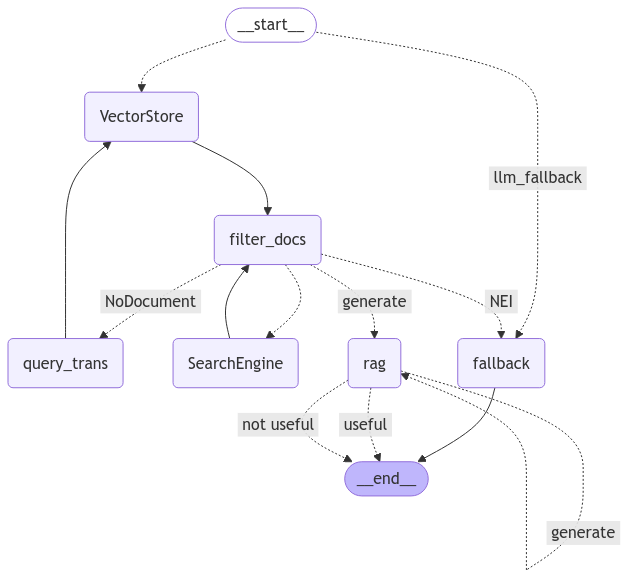

In [103]:
from io import BytesIO
from PIL import Image
from IPython.display import display

# Assuming you have the byte image stream in the 'byte_image' variable
img = Image.open(BytesIO(plot))
display(img)

In [104]:
for token in app.stream({"query": "雇用主は従業員を解雇する場合、少なくとも 40 日前に通知する必要があります。", "chat_history": []}):
    print(token, end="", flush=True)

---Routing to VectorStore LaborLawsVectorStore---
vao yes embed

====retrieval_node====
{'VectorStore': {'documents': [Document(metadata={'law_number': '昭和二十二年法律第四十九号', 'law_name': '労働基準法', 'enactment_year': '令和6年5月31日 施行', 'chapter_number': '第二章', 'chapter_name': '労働契約', 'division_number': '', 'division_name': '', 'article_number': '第十三条', 'article_name': 'この法律違反の契約', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約/第十三条\u3000この法律違反の契約/この法律で定める基準に達しない労働条件を定める労働契約は、その部分については無効とする。この場合において、無効となつた部分は、この法律で定める基準による。'), Document(metadata={'law_number': '昭和四十九年法律第百十六号', 'law_name': '雇用保険法', 'enactment_year': '令和6年10月1日 施行', 'chapter_number': '第三章', 'chapter_name': '失業等給付', 'division_number': '第四節', 'division_name': '日雇労働被保険者の求職者給付', 'article_number': '第四十五条', 'article_name': '日雇労働求職者給付金の受給資格', 'document_source': 'https://laws.e-gov.go.jp/law/349AC0000000116'}, page_content='昭和四十九年法律第百十六号\u3000雇用保険法/第三章\u3000失業等給付/第四節\u3

In [105]:
response_app = app.invoke({"query": "雇用主は従業員を解雇する場合、少なくとも 40 日前に通知する必要があります。", "chat_history": []})

---Routing to VectorStore LaborLawsVectorStore---
vao yes embed

====retrieval_node====
====filter_documents_node====
---DOCUMENT 1: NOT RELEVANT---
---DOCUMENT 2: NOT RELEVANT---
---DOCUMENT 3: NOT RELEVANT---
---DOCUMENT 4: NOT RELEVANT---
---DOCUMENT 5: NOT RELEVANT---
---DOCUMENT 6: NOT RELEVANT---
---DOCUMENT 7: NOT RELEVANT---
---DOCUMENT 8: NOT RELEVANT---
---DOCUMENT 9: NOT RELEVANT---
---DOCUMENT 10: RELEVANT---
---DOCUMENT 11: NOT RELEVANT---
---DOCUMENT 12: NOT RELEVANT---
---DOCUMENT 13: NOT RELEVANT---
---DOCUMENT 14: NOT RELEVANT---
---Some retrived documents are relevant---
====rag_node====
len(documents) 1
[Document(metadata={'law_number': '昭和二十二年法律第四十九号', 'law_name': '労働基準法', 'enactment_year': '令和6年5月31日 施行', 'chapter_number': '第二章', 'chapter_name': '労働契約', 'division_number': '', 'division_name': '', 'article_number': '第二十条', 'article_name': '解雇の予告', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約

In [106]:
response_app

{'query': '雇用主は従業員を解雇する場合、少なくとも 40 日前に通知する必要があります。',
 'chat_history': [],
 'generation': '- 結論: 「誤り」\n- 説明: 本契約条項は、労働基準法第二十条に基づいて、雇用主が従業員を解雇する場合、少なくとも30日前に通知する必要があると規定しているが、本契約条項では40日前に通知する必要があると規定しているため、誤りである。',
 'documents': [Document(metadata={'law_number': '昭和二十二年法律第四十九号', 'law_name': '労働基準法', 'enactment_year': '令和6年5月31日 施行', 'chapter_number': '第二章', 'chapter_name': '労働契約', 'division_number': '', 'division_name': '', 'article_number': '第二十条', 'article_name': '解雇の予告', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約/第二十条\u3000解雇の予告/使用者は、労働者を解雇しようとする場合においては、少くとも三十日前にその予告をしなければならない。三十日前に予告をしない使用者は、三十日分以上の平均賃金を支払わなければならない。但し、天災事変その他やむを得ない事由のために事業の継続が不可能となつた場合又は労働者の責に帰すべき事由に基いて解雇する場合においては、この限りでない。\n前項の予告の日数は、一日について平均賃金を支払つた場合においては、その日数を短縮することができる。\n前条第二項の規定は、第一項但書の場合にこれを準用する。')]}

In [107]:
chat_history = []
chat_history.append({
    'index': 0,
    'query': '雇用主は従業員を解雇する場合、少なくとも 40 日前に通知する必要があります。', 
    'generation': '- 結論: 「誤り」\n- 説明: 本契約条項は、労働基準法第二十条に基づいて、雇用主が従業員を解雇する場合、少なくとも30日前に通知する必要があると規定しているが、本契約条項では40日前に通知する必要があると規定しているため、誤りである。',
    'documents': [Document(metadata={'law_number': '昭和二十二年法律第四十九号', 'law_name': '労働基準法', 'enactment_year': '令和6年5月31日 施行', 'chapter_number': '第二章', 'chapter_name': '労働契約', 'division_number': '', 'division_name': '', 'article_number': '第二十条', 'article_name': '解雇の予告', 'document_source': 'https://laws.e-gov.go.jp/law/322AC0000000049'}, page_content='昭和二十二年法律第四十九号\u3000労働基準法/第二章\u3000労働契約/第二十条\u3000解雇の予告/使用者は、労働者を解雇しようとする場合においては、少くとも三十日前にその予告をしなければならない。三十日前に予告をしない使用者は、三十日分以上の平均賃金を支払わなければならない。但し、天災事変その他やむを得ない事由のために事業の継続が不可能となつた場合又は労働者の責に帰すべき事由に基いて解雇する場合においては、この限りでない。\n前項の予告の日数は、一日について平均賃金を支払つた場合においては、その日数を短縮することができる。\n前条第二項の規定は、第一項但書の場合にこれを準用する。')]
})

In [108]:
query_contracts = [
    "雇用主は従業員を解雇する場合、少なくとも 40 日前に通知する必要があります。",
    "解雇の予告期間は労働基準法に基づき、最低30日とするが、当社は40日間の通知期間を設ける。",
    "40日分の平均賃金を支払う場合は、予告期間を短縮することができる。",
    "解雇の予告は労働基準法に準じ、30日以内とする。",
    "即時解雇の場合、予告期間は不要である。",
    "有給休暇は入社後6か月経過後に付与されます。",
    "従業員は業務中に安全規則を遵守しなければなりません。"
]

In [ ]:
import numpy as np
import torch
from sentence_transformers import util

# Danh sách câu hợp đồng
query_contracts = [ 
    "解雇の予告期間は労働基準法に基づき、最低30日とするが、当社は40日間の通知期間を設ける。",
    "40日分の平均賃金を支払う場合は、予告期間を短縮することができる。",
    "解雇の予告は労働基準法に準じ、30日以内とする。",
    "即時解雇の場合、予告期間は不要である。",
    "有給休暇は入社後6か月経過後に付与されます。",
    "従業員は業務中に安全規則を遵守しなければなりません。"
]

# Câu truy vấn
query = "雇用主は従業員を解雇する場合、少なくとも 40 日前に通知する必要があります。"

# Mã hóa câu truy vấn
query_emb = retrieval.encode_question(query)

# Đảm bảo query_emb có cùng kích thước
query_emb = np.array(query_emb, dtype=np.float32)
if query_emb.ndim == 1:
    query_emb = query_emb.reshape(1, -1)

# Mã hóa danh sách câu hợp đồng
query_contracts_emb = retrieval.encode_question(query_contracts)

# Chuyển danh sách embeddings thành mảng NumPy
query_contracts_emb = np.array([np.array(e, dtype=np.float32) for e in query_contracts_emb])

# Tính cosine similarity giữa query và các câu hợp đồng
cos_sim = util.cos_sim(torch.tensor(query_emb), torch.tensor(query_contracts_emb))

# Lấy chỉ số của câu có độ tương đồng cao nhất
top_match_idx = torch.argmax(cos_sim).item()

# In câu liên quan nhất
print("Câu hợp đồng liên quan nhất:")
print(query_contracts[top_match_idx])


In [109]:
# list_emb_models = []
# for model in self.models:
#     emb2_list = [model.encode(doc["content"]) for doc in doc_data]
#     list_emb_models.append(np.array(emb2_list))
# return list_emb_models

In [110]:
import numpy as np

def pad_embeddings(embeddings, target_dim):
    """Đưa tất cả embeddings về cùng kích thước bằng cách thêm padding."""
    padded_embeddings = []
    for emb in embeddings:
        emb = np.array(emb, dtype=np.float32)
        if emb.shape[0] < target_dim:
            # Padding nếu nhỏ hơn target_dim
            pad_width = target_dim - emb.shape[0]
            emb = np.pad(emb, (0, pad_width), mode='constant', constant_values=0)
        elif emb.shape[0] > target_dim:
            # Cắt bớt nếu lớn hơn target_dim
            emb = emb[:target_dim]
        padded_embeddings.append(emb)
    
#     return np.array(padded_embeddings, dtype=np.float32)

# query_emb = retrieval.encode_question(query)

# # Chuyển danh sách các embeddings thành mảng NumPy có cùng kích thước
# query_emb = pad_embeddings(query_emb, target_dim=768)



In [111]:
dict_relevant_query = {}
embed_query_history = []

for idx, query in enumerate(query_contracts): 
    print(idx)
    query_emb = retrieval.encode_question(query)
    query_emb = pad_embeddings(query_emb, target_dim=768)
    embed_query_history.append(query_emb)

    if isinstance(query_emb, list):
        query_emb = [np.array(e, dtype=np.float32) for e in query_emb] 
        
    # Kiểm tra và chuẩn hóa query_emb
    query_emb = np.array(query_emb)  # Chuyển về dạng số thực
    
    print(query_emb.shape)  # Kiểm tra kích thước của query_emb
    
    if embed_query_history == []: 
        relevant_query = []
    else:
        # Tìm kiếm liên quan của câu query hiện tại với các query trong history
        print(np.array(embed_query_history).shape)
        map_ids, new_scores = retrieval.inference(query, embed_query_history)
        print(map_ids)

    embed_query_history.append(query_emb)


0
()
(1,)
vao no embed


RuntimeError: Could not infer dtype of NoneType

In [ ]:
# sử dụng retrieval trong hợp đồng
dict_relevant_query = {}
embed_query_history = []

for idx, query in enumerate(query_contracts): 
    print(idx)
    query_emb = retrieval.encode_question(query)
    print(len(query_emb[2]))
    if embed_query_history==[]: 
        relevant_query = []
    else:
        #tìm kiếm liên quan của câu query hiện tại với các query trong history
        map_ids, new_scores = retrieval.inference(query, embed_query_history)
        print(map_ids)
    embed_query_history.append(np.array(query_emb, dtype=object))


0
768
1
768


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:


chat_history = []

for idx, query in enumerate(query_contracts): 
    response_app = app.invoke({"query": query, "chat_history": []})
    chat_history.append({
        "index": idx,
        "query": query,
        "generation": response_app.generation,
        "documents": response_app.documents
    })


## History + RAG

- chunk tiếp theo sẽ dùng retrieval tìm ra top 5 chunks liên quan nhất đến chunks hiện tại và qua LLMs đánh giá. Nếu thực sự liên quan thì sẽ lấy history của chunk trước bỏ vào để trả lời câu hiện tại. (phuc)